In [56]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches

im = cv2.imread('Data/car11.jpeg')
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# img = cv2.drawContours(im, contours, -1, (0,255,0), 3)

image_area = im.shape[0]*im.shape[1]
# print(image_area)

plate_like_objects=[]
dims=[]
final = 999
for i,cnt in enumerate(contours) :
    area = cv2.contourArea(cnt)
    if(area > 0.01*image_area):
        x,y,w,h = cv2.boundingRect(cnt)
        plate = im[y:y+h,x:x+w]
        dims.append([x,y,w,h])
        plate_like_objects.append(plate)

for i in range(len(plate_like_objects)):
    image = plate_like_objects[i]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     gray = cv2.threshold(gray, 0, 255,    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

    # make a check to see if median blurring should be done to remove
    # noise
    gray = cv2.medianBlur(gray, 3)

    license_plate = np.invert(gray)

    labelled_plate = measure.label(license_plate)
    character_dimensions = (0.10*license_plate.shape[0], 0.80*license_plate.shape[0], 0.01*license_plate.shape[1], 0.80*license_plate.shape[1])
    min_height, max_height, min_width, max_width = character_dimensions

    characters = []
    counter=0
    for regions in regionprops(labelled_plate):
        y0, x0, y1, x1 = regions.bbox
        region_height = y1 - y0
        region_width = x1 - x0

        if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
            roi = license_plate[y0:y1, x0:x1]

            resized_char = resize(roi, (20, 20))
            characters.append(resized_char)

    if(len(characters) > 8 ):
        final = i
        break



/home/local/ALGOANALYTICS/arun/arun_work/ML/py3.6_NN/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/local/ALGOANALYTICS/arun/arun_work/ML/py3.6_NN/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [57]:
len(characters),final

(19, 0)

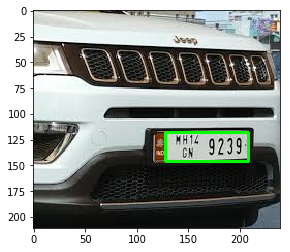

In [58]:
x,y,w,h = dims[final]
img2  = cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(img2)
plt.show()

In [34]:
final

4

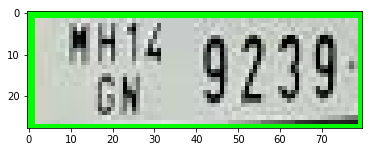

In [59]:
image = im[y:y+h,x:x+w]
plt.imshow(image)

/home/local/ALGOANALYTICS/arun/arun_work/ML/py3.6_NN/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/local/ALGOANALYTICS/arun/arun_work/ML/py3.6_NN/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


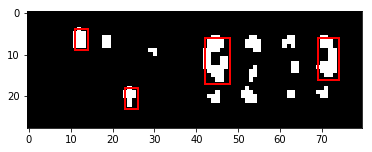

In [60]:
image = im[y:y+h,x:x+w]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# check to see if we should apply thresholding to preprocess the
# image

gray = cv2.threshold(gray, 0, 255,    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# make a check to see if median blurring should be done to remove
# noise
gray = cv2.medianBlur(gray, 3)

license_plate = np.invert(gray)

labelled_plate = measure.label(license_plate)
character_dimensions = (0.15*license_plate.shape[0], 0.80*license_plate.shape[0], 0.02*license_plate.shape[1], 0.80*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")

characters = []
counter=0
column_list_x = []
column_list_y = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)

        # this is just to keep track of the arrangement of the characters
        column_list_x.append(x0)
        column_list_y.append(y0)
    
plt.show()

In [12]:
len(characters)

10

In [18]:
import os
from sklearn.externals import joblib

current_dir = os.path.dirname(os.path.realpath('__file__'))
model_dir = os.path.join(current_dir, 'models/svc/svc.pkl')
model = joblib.load(model_dir)

classification_result = []
for each_character in characters:
    # converts it to a 1D array
    each_character = each_character.reshape(1, -1);
    result = model.predict(each_character)
    classification_result.append(result)

print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]

print(plate_string)

# it's possible the characters are wrongly arranged
# since that's a possibility, the column_list will be
# used to sort the letters in the right order

column_list_y = [int(x > min(column_list_y)+10) for x in column_list_y]
column_list_copy = column_list_x[:]

zipped_pairs = zip(column_list_y, column_list_x)
column_list = [x for _, x in sorted(zipped_pairs)]

# column_list_copy = column_list[:]
# column_list = sorted(column_list, key=lambda x: x[1])
rightplate_string = ''
for each in column_list:
    rightplate_string += plate_string[column_list_copy.index(each)]

print(rightplate_string)

[array(['3'], dtype='<U1'), array(['3'], dtype='<U1'), array(['E'], dtype='<U1'), array(['1'], dtype='<U1'), array(['4'], dtype='<U1'), array(['M'], dtype='<U1'), array(['H'], dtype='<U1'), array(['1'], dtype='<U1'), array(['Z'], dtype='<U1'), array(['0'], dtype='<U1')]
33E14MH1Z0
MH1Z0E1433
